# Базовый анализ

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Загрузим наши предобработанные данные

In [3]:
tourney_hand_summary = pd.read_csv('input\\tourney_hand_summary_03_18_18.csv')

## Проведем базовый анализ рейза с UTG (первая позиция).
Отфильтруем нашу таблицу таким образом, чтобы оставить только раздачи, где был сделан рейз (повышение ставки) с позиции UTG (первый кто ходит на префлопе).

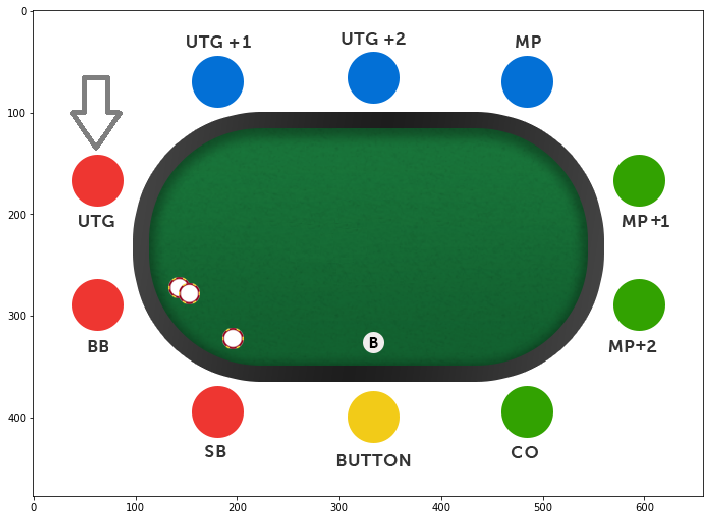

In [8]:
plt.figure(figsize=(12, 9))
img = mpimg.imread('pictures/positions_UTG.png')
plt.imshow(img);

In [9]:
tourney_hand_summary['UTG_act_p_1']  = tourney_hand_summary['UTG_act_p'].apply(lambda x: str(x)[:1])

In [10]:
# Отфильтруем
data_UTG = tourney_hand_summary[tourney_hand_summary.UTG_act_p_1=='R']

In [11]:
data_UTG.columns

Index(['Unnamed: 0', 'id_hand', 'id_blinds', 'id_table', 'hand_no',
       'cnt_players', 'id_table.1', 'cnt_players.1',
       'cnt_players_lookup_position', 'cnt_players_f', 'cnt_players_t',
       'cnt_players_r', 'amt_pot', 'amt_short_stack', 'amt_pot_p', 'amt_pot_f',
       'amt_pot_t', 'amt_pot_r', 'str_actors_p', 'str_actors_f',
       'str_actors_t', 'str_actors_r', 'str_aggressors_p', 'str_aggressors_f',
       'str_aggressors_t', 'str_aggressors_r', 'id_win_hand', 'id_win_hand_lo',
       'id_winner', 'id_winner_lo', 'button', 'card_1', 'card_2', 'card_3',
       'card_4', 'card_5', 'UTG_bb', 'UTG_1_bb', 'MP_bb', 'MP_1_bb', 'MP_2_bb',
       'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'UTG_card', 'UTG_1_card',
       'MP_card', 'MP_1_card', 'MP_2_card', 'CO_card', 'BUTTON_card',
       'SB_card', 'BB_card', 'UTG_act_p', 'UTG_1_act_p', 'MP_act_p',
       'MP_1_act_p', 'MP_2_act_p', 'CO_act_p', 'BUTTON_act_p', 'SB_act_p',
       'BB_act_p', 'UTG_amt_b_p', 'UTG_1_amt_b_p', 'MP_amt_b

#### Оставим для анализа только необходимые нам столбцы
- Карты игрока, сидящего на первой позиции(UTG)
- Ставку на префлопе этого игрока
- Стеки игроков
- Ожидаемый выигрыш игрока (UTG)

In [12]:
data_UTG = data_UTG[['UTG_card', 'UTG_amt_b_p', 'UTG_bb', 'UTG_1_bb', 'MP_bb', 'MP_1_bb',
                     'MP_2_bb', 'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'UTG_amt_exp']]

#### Разметим выиграш игрока
Если больше 0, то класс равен 1, иначе 0.

In [13]:
data_UTG['profit'] = np.where(data_UTG.UTG_amt_exp > 0, 1, 0)
del data_UTG['UTG_amt_exp']

#### Посмотрим какие руки чаще всего разыгрывают с позициии UTG

In [15]:
dist_cards = np.array(data_UTG.UTG_card.value_counts()[:10].reset_index())

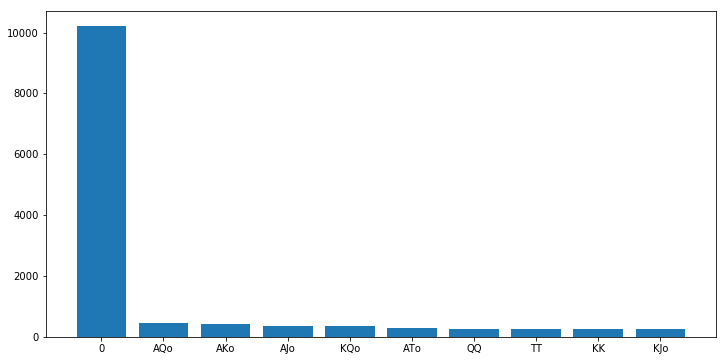

In [16]:
x = np.arange(10)
plt.figure(figsize=(12, 6))
plt.bar(x, dist_cards[:, 1])
plt.xticks(x, dist_cards[:, 0])
plt.show();

Чаще всего нам неизвестна рука, оставим только известные руки для анализа

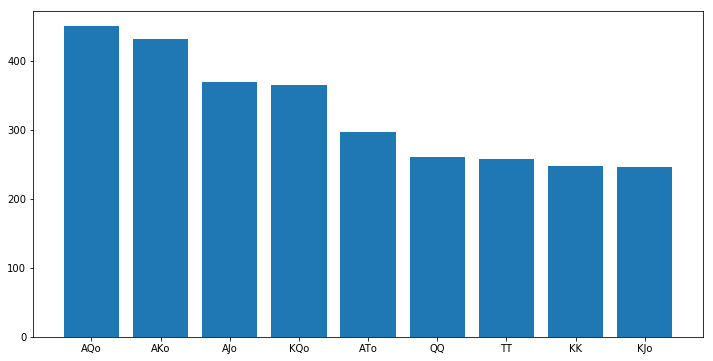

In [17]:
x = np.arange(9)
plt.figure(figsize=(12, 6))
plt.bar(x, dist_cards[1:, 1])
plt.xticks(x, dist_cards[1:, 0])
plt.show();

In [18]:
data_UTG.shape

(18993, 12)

## Решение Baseline
Посмотрим на точность разных моделей. Будем оценивать по метрике F1-score. Подходит из-за того, что у нас есть разбалансировка классов.
В базовом анализе следующие признаки:
 - Карты игрока, сидящего на первой позиции(UTG)
 - Ставку на префлопе этого игрока
 - Стеки игроков
 - Прибыль игрока (UTG)


In [19]:
from sklearn.model_selection import train_test_split
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

In [21]:
X = data_UTG.copy()
y = data_UTG['profit']
del X['profit']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
model = CatBoostClassifier(iterations=500, depth=5, learning_rate=0.03, loss_function='Logloss')

In [24]:
model.fit(X_train, y_train, cat_features=[0], verbose=False)

In [26]:
preds_class = model.predict(X_test)

In [27]:
print(classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.61      0.47      0.53      1554
          1       0.69      0.79      0.74      2245

avg / total       0.66      0.66      0.65      3799



### Проверим другие модели 
#### KNeighborsClassifier 

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:
knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)

In [30]:
X_dummy = pd.get_dummies(X, columns=['UTG_card'])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.2, random_state=42)

In [32]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

In [33]:
preds_class_knn = knn.predict(X_test)

In [34]:
print(classification_report(y_test, preds_class_knn))

             precision    recall  f1-score   support

          0       0.43      0.55      0.48      1543
          1       0.62      0.49      0.55      2256

avg / total       0.54      0.52      0.52      3799



#### SVM 

In [35]:
from sklearn.svm import SVC

In [36]:
clf = SVC()

In [37]:
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
preds_class_svm = clf.predict(X_test)

In [39]:
print(classification_report(y_test, preds_class_svm))

             precision    recall  f1-score   support

          0       0.43      0.09      0.15      1543
          1       0.60      0.92      0.72      2256

avg / total       0.53      0.58      0.49      3799



#### GaussianNB

In [40]:
from sklearn.naive_bayes import GaussianNB

In [41]:
gnb = GaussianNB()

In [42]:
gnb.fit(X_train, y_train)

GaussianNB(priors=None)

In [43]:
preds_class_gnb = gnb.predict(X_test)

In [44]:
print(classification_report(y_test, preds_class_gnb))

             precision    recall  f1-score   support

          0       0.70      0.14      0.23      1543
          1       0.62      0.96      0.75      2256

avg / total       0.65      0.63      0.54      3799



### Первые итоги. 
* По первым результам catboost дает лучшие результаты. Подбирать параметры будем к нему. 
* В первом приближении мы использовали только стеки за столом. Попробуем расширить количество признаков: 
 - посчитаем сколько необходимо заплатить каждой позиции для продолжения игры (пот-оддсы)
 - переведем стеки в категориальные признаки